In [1]:
from functools import partial
## Animation Libraries Used
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Model training libraies
import numpy as np
import matplotlib as mpl
import seaborn as sn
import os
import json
import sys

from pathlib import Path
import IPython
from IPython.display import display
from IPython.display import HTML

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

In [2]:
# first sign video frame file as sample to see the frame data 
# it has face, left
filename = "test.parquet"
sample_sign_df = pd.read_parquet(filename)
sample_sign_df.y = sample_sign_df.y * -1
print(sample_sign_df)

      frame            row_id        type landmark_index         x         y  \
0         0          0-face-0        face              0  0.719802 -0.840854   
1         0          0-face-1        face              1  0.737908 -0.797057   
2         0          0-face-2        face              2  0.726390 -0.807249   
3         0          0-face-3        face              3  0.734068 -0.735141   
4         0          0-face-4        face              4  0.742087 -0.780956   
...     ...               ...         ...            ...       ...       ...   
27145    49  49-right_hand-16  right_hand             16  0.000000 -0.000000   
27146    49  49-right_hand-17  right_hand             17  0.000000 -0.000000   
27147    49  49-right_hand-18  right_hand             18  0.000000 -0.000000   
27148    49  49-right_hand-19  right_hand             19  0.000000 -0.000000   
27149    49  49-right_hand-20  right_hand             20  0.000000 -0.000000   

              z  
0     -0.024457  
1  

In [3]:
print(sample_sign_df['frame'].nunique()) # number of frames in this video of "blow" sign

50


In [4]:
sample_sign_df.dtypes

frame              object
row_id             object
type               object
landmark_index     object
x                 float64
y                 float64
z                 float64
dtype: object

In [5]:
# choose features - landmarks to use for classification
# Google mediapipe landmarks index: 468 face landmarks, 21 landmarks for each hand, and 
# https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#:~:text=The%20MediaPipe%20Pose%20Landmarker%20task,with%20single%20images%20or%20video.
# The pose consists of a total of 33 landmark points with indices from 0 to 32. 
# pose : 0-10 are assigned to the face, 11-22 to the upper body, and 23-32 to the lower body.

# https://medium.com/@hotakoma/mediapipe-landmark-face-hand-pose-sequence-number-list-view-778364d6c414
# here in the sign video, each frame has 543 landmards:     
#    face: 0:468
#     left_hand: 468:489
#     pose: 489:522
#     right_hand: 522:544

# More resource: https://www.youtube.com/watch?v=hV5S4iQhNkI

# sample_sign_df[sample_sign_df['type'] == "face"].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'pose')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'left_hand')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'right_hand')].landmark_index

In [6]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

In [7]:
def animation_frame(f, sign_df):
    frame = sign_df[sign_df.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

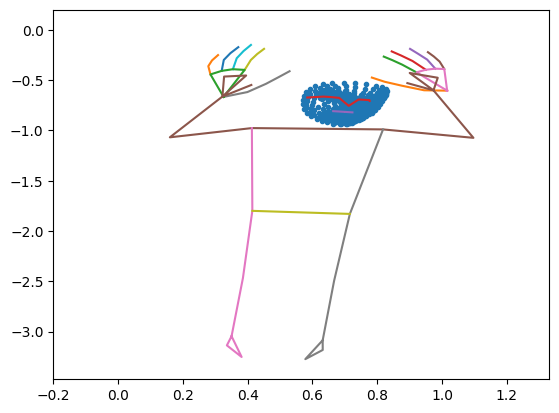

In [8]:
## These values set the limits on the graph to stabilize the video
xmin = sample_sign_df.x.min() - 0.2
xmax = sample_sign_df.x.max() + 0.2
ymin = sample_sign_df.y.min() - 0.2
ymax = sample_sign_df.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
fun_animation = FuncAnimation(fig, func=partial(animation_frame, sign_df=sample_sign_df), frames=sample_sign_df.frame.unique())

HTML(fun_animation.to_html5_video())

In [9]:
# 3D visualization 
# https://www.kaggle.com/code/ted0071/gislr-visualization

In [10]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [20]:
# def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
#     """Reads the sign to predict as json file."""
#     with open(file_path, "r") as f:
#         result = json.load(f)
#     return result    

# def read_train(file_path=Cfg.TRAN_FILE):
#     """Reads the train csv as pandas data frame."""
#     return pd.read_csv(file_path).set_index(Cfg.INDEX)

# def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
#     """Reads landmak data by the given file path."""
#     data = pd.read_parquet(input_root / file_path)
#     return data.set_index(Cfg.ROW_ID)

# def read_landmark_data_by_id(sequence_id, train_data):
#     """Reads the landmark data by the given sequence id."""
#     file_path = train_data.loc[sequence_id]['path']
#     return read_landmark_data_by_path(file_path)



mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

def get_random_sequence_id(train_data):
    idx = np.random.randint(0, len(train_data))
    return train_data.index[idx]

# def create_blank_image(height, width):
#     return np.zeros((height, width, 3), np.uint8)

def create_blank_image(height, width):
    return np.ones((height, width, 3), np.uint8)

def draw_landmarks(
    data, 
    image, 
    frame_id, 
    landmark_type, 
    connection_type, 
    landmark_color=(255, 0, 0), 
    connection_color=(0, 20, 255), 
    thickness=1, 
    circle_radius=1
):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type))
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)

    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

def draw_left_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='left_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_right_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='right_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_face(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='face', 
        connection_type=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_color=(255, 255, 255),
        connection_color=(0, 255, 0))      
    
def draw_pose(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='pose', 
        connection_type=mp_pose.POSE_CONNECTIONS,
#         landmark_color=(255, 255, 255),
#         connection_color=(255, 0, 0),
        landmark_color=(255, 0, 0),
        connection_color=(0, 255, 0),
        thickness=2, 
        circle_radius=2)

def create_frame(data, frame_id, height=1000, width=1000):
    image = create_blank_image(height, width)    

    draw_pose(data, image, frame_id) 
    draw_left_hand(data, image, frame_id)    
    draw_right_hand(data, image, frame_id)  
    draw_face(data, image, frame_id)
     
    return image

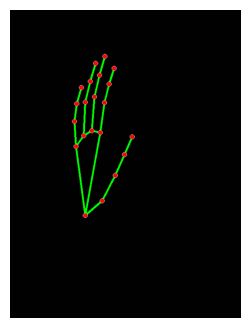

In [21]:
height = 800
width = 600
data = sample_sign_df = pd.read_parquet(filename)

frame_id = data['frame'][20]

_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_right_hand(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

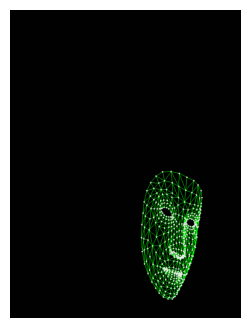

In [22]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_face(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

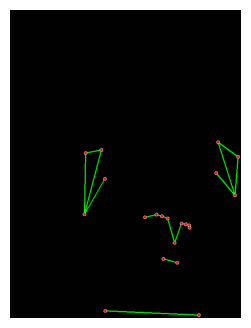

In [23]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_pose(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

/tmp/ipykernel_34/1992613220.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame_id = data['frame'][0]


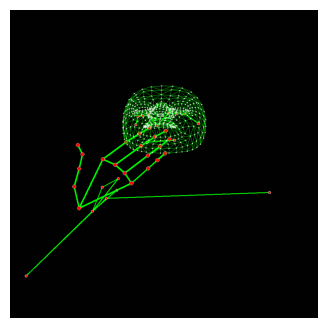

In [33]:
train_data = read_train()

def read_landmark_data_by_sign(sign_string, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data[train_data['sign'] == sign_string].iloc[0]['path']
    return read_landmark_data_by_path(file_path)

height = 800
width = 600


data = read_landmark_data_by_sign("thankyou", train_data)
frame_id = data['frame'][0]

_, ax = plt.subplots(1, 1, figsize=(4, 4))

image = create_frame(data, frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')
plt.savefig('/kaggle/working/thankyou_plot.png', dpi=300)
plt.show()

In [24]:
def create_frames(data, height=800, width=800):
    frame_ids = data['frame'].unique()
    images = [create_frame(data, frame_id=fid, height=height, width=width) for fid in frame_ids]
    return np.array(images)


def create_animation(images, fig, ax):
    ax.axis('off')
    
    ims = []
    for img in images:
        im = ax.imshow(img, animated=True)
        ims.append([im])
    
    func_animation = mpl.animation.ArtistAnimation(
        fig, 
        ims, 
        interval=100, 
        blit=True,
        repeat_delay=1000)

    return func_animation


def play_animation(data, height, width, figsize=(4, 4)):
    frames = create_frames(data, height=height, width=width)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    
    video = anim.to_html5_video()
    html = IPython.display.HTML(video)
    IPython.display.display(html)
    plt.close()

In [25]:
play_animation(data=data, height=height, width=width)

In [29]:
def create_gif(data, height, width, figsize=(4, 4)):
    frames = create_frames(data, height=height, width=width)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    # Save the animation as a GIF
    anim.save('sign.gif', writer='pillow')
    plt.close()

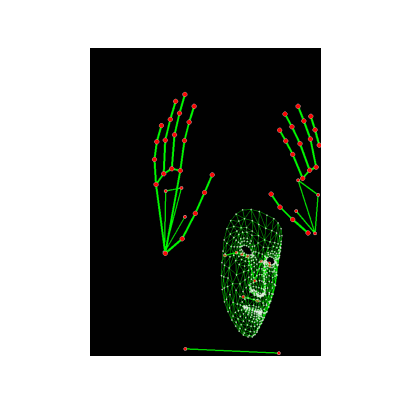

In [30]:
create_gif(data, height=height, width=width)
# Display the GIF
IPython.display.Image(filename='sign.gif')

In [33]:
def save_each_frame(data, foldername, height, width, figsize=(4, 4)):
    if not os.path.exists(foldername):
        os.makedirs(foldername)
        
    frames = create_frames(data, height=height, width=width)
    fig, ax = plt.subplots(figsize=figsize)
    for i, frame in enumerate(frames):
        ax.clear()  # Clear the previous frame
        ax.imshow(frame)
        ax.axis('off')  # Hide the axis
        plt.savefig(f'{foldername}/frame_{i:03d}.png')
    plt.close(fig)  # Close the figure after saving all frames

In [35]:
save_each_frame(data, foldername='gif_frames', height=height, width=width)